In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from denn import *
import pandas as pd
import seaborn as sns
import io #Used as buffer

# Functions

In [3]:
nn_p=3
path= Path(f'../../data/cluster_results')
col_by_freq = True
col_palette = 'Set3'
pat = re.compile('.*/(exp\d)/(\w*)/nonn/freq([0-9\.]+)div(\w+)/(\w+)_\w+.csv')
decode_keys = ['experiment','function','freq','div','method']
nn_pat = re.compile('.*/(exp\d)/(\w*)/nn/freq([0-9\.]+)\w+nn_p(\d+)\w+div([A-Za-z]+)/(\w+)_(\w+)_\w+.csv')
nn_decode_keys = ['experiment','function','freq','nnp','div','method','replace_mech']

def get_files(m): return list(path.glob(f'**/nonn/**/*{m}.csv'))
def get_nn_files(m): return list(path.glob(f'**/nn/**/*{m}.csv'))

def read_csv(f,m):
    df = pd.read_csv(f)
    for k,v in zip(decode_keys,pat.search(str(f)).groups()): df[k] = v
    df['freq'] = df['freq'].astype(float)
    df['method'] = df['method'] + '_' + df['div']
#     df['method'] = df['method'].str.replace('noNNRestart', 'noNN_Rst')
    df['method'] = df['method'].str.replace('noNNRestart_No', 'noNN_Rst')
    df.drop('div', axis=1, inplace=True)
    df.rename({'0':m.upper(), m:m.upper()}, axis=1, inplace=True)
    return df

def read_nn_csv(f,m):
    df = pd.read_csv(f)
    for k,v in zip(nn_decode_keys,nn_pat.search(str(f)).groups()): df[k] = v
    df['freq'] = df['freq'].astype(float)
    df['method'] = df['method'] + '_' + df['replace_mech'] + '_' + df['div']
    df['method'] = df['method'].str.replace('NNnorm_Worst', 'NN')
    df.drop(['replace_mech','div'], axis=1, inplace=True)
    df.rename({'0':m.upper(), m:m.upper()}, axis=1, inplace=True)
    return df

def get_data(m, normalize=False):
    files = get_files(m)
    nn_files = get_nn_files(m)
    data = pd.concat([read_csv(f,m) for f in files] + [read_nn_csv(f,m) for f in nn_files])
    data=data.query('freq>1')
    if normalize:
        data_norm = (data.groupby(['experiment','function','freq','method'])[m.upper()].mean().reset_index()
                         .groupby(['experiment','function'])[m.upper()].min().reset_index()
                         .rename({m.upper():m.upper()+'_norm'}, axis=1))
        data = data.merge(data_norm, 'left')
        data[m.upper()+'_norm'] = data[m.upper()] / data[m.upper()+'_norm']
    return data.reset_index(drop=True)
    return data

def plot_one(data, m, normalize=False, title='', title_size=14, col_by_freq=col_by_freq, col_palette=col_palette,
             legend=False, hide_x=True, hide_y=True, ax=None, do_lim=True, ll=0.2, ul=0.8):
    m = m.upper()
    if normalize: m = m + '_norm' 
    if ax is None: fig,ax = plt.subplots(1,1,figsize=(6,4))
    sns.boxplot('method' if col_by_freq else 'freq', m, hue='freq' if col_by_freq else 'method',
                data=data, palette=col_palette,
                # width=2.5,
                linewidth=0.5, fliersize=0, ax=ax)
    if not legend: ax.get_legend().remove()
    if do_lim:
        ax.set_ylim(-0.05,1.05)
    else:
        g = data.groupby(['method','freq'])[m]
        q1,q3 = g.quantile(ll),g.quantile(ul)
        iqr = q3-q1
        lower_lim = (q1 - 1.5*iqr).min()
        upper_lim = (q3 + 1.5*iqr).max()
        lower_lim = data[m][data[m]>=lower_lim].min()
        upper_lim = data[m][data[m]<=upper_lim].max()
        ax.set_ylim(lower_lim,upper_lim)
        
    ax.set_xlabel('')
    if hide_x: ax.set_xticklabels([])
    if hide_y: ax.set_ylabel('')
    ax.set_title(title, size=title_size)
    return ax

def plot_all_vertical(m, normalize=False, title_size=14, col_by_freq=col_by_freq, col_palette=col_palette, do_lim=True,
                      ll=0.2, ul=0.8):
    data = get_data(m, normalize=normalize)
#     fig,axss = plt.subplots(4, 3, figsize=(14,16), sharex=do_lim, sharey=do_lim)
    fig,axss = plt.subplots(4, 3, figsize=(26,18), sharex=False, sharey=False)
    for i,(axs,exp) in enumerate(zip(axss,['exp1','exp2','exp3','exp4'])):
        first_exp = i==0
        for j,(ax,func) in enumerate(zip(axs,['sphere', 'rosenbrock', 'rastrigin'])):
            first_func = j==0
            test = data.query(f'experiment=={exp!r} and function=={func!r}').sort_values('method', ascending=False)
            plot_one(test, m, normalize=normalize, title=f'{exp}-{func.title()}', title_size=title_size, hide_x=False,
                     hide_y=not first_func, col_by_freq=col_by_freq, col_palette=col_palette, ax=ax,
                     do_lim=do_lim, ll=ll, ul=ul)
        ax.legend(loc='upper left', ncol=3)
    plt.tight_layout()
    return fig,axss

def plot_all_horizontal(m, normalize=False, title_size=14, col_by_freq=col_by_freq, col_palette=col_palette, do_lim=True,
                        ll=0.2, ul=0.8):
    data = get_data(m, normalize=normalize)
#     fig,axss = plt.subplots(4, 3, figsize=(14,16), sharex=do_lim, sharey=do_lim)
    fig,axss = plt.subplots(3, 4, figsize=(28,20), sharex=False, sharey=False)#20,12
    for i,exp in enumerate(['exp1','exp2','exp3','exp4']):#
        first_exp = i==0
        axs = axss[:,i]
        for j,(ax,func) in enumerate(zip(axs,['sphere', 'rosenbrock', 'rastrigin'])):
            first_func = i==0
            test = data.query(f'experiment=={exp!r} and function=={func!r}').sort_values('method', ascending=False)
            plot_one(test, m, normalize=normalize, title=f'{exp}-{func.title()}', title_size=title_size, hide_x=False,
                     hide_y=not first_func, col_by_freq=col_by_freq, col_palette=col_palette, ax=ax,
                     do_lim=do_lim, ll=ll, ul=ul)
        
    for axs in axss: axs[-1].legend(loc='upper right', ncol=3)
    plt.tight_layout()
    return fig,axss

# Plots

In [4]:
labels_order = ['noNN_RI', 'noNN_HMu', 'noNN_CwN', 'noNN_No', 'noNN_Rst', 'NN_RI',
                'NN_HMu', 'NN_CwN', 'NN_No']

In [5]:
def get_heatmap_data(m):
    df = get_data(m)
    df = df[df.nnp.isna() | (df.nnp == str(nn_p))].drop('nnp', axis=1)

    df.function = df.function.str.title()
    m = m.upper()
    df_pivot = df.pivot_table(index=['experiment','function','freq'], columns=['method'], values=[m])[m]
    return df_pivot

In [6]:
df_pivot = get_heatmap_data('sr')[labels_order]
#df_pivot_rank = df_pivot.rank(axis=1, ascending=False)
df_pivot = df_pivot.reset_index()
df_pivot.experiment = df_pivot.experiment.str.slice(3)
df_pivot.set_index(['experiment','function','freq'], inplace=True)

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [7]:
df_pivot.style.background_gradient(cmap=plt.cm.Greens, axis=1)

In [8]:
summary = df_pivot.groupby(['experiment','function']).mean() #

summary.round(2).style.background_gradient(cmap=plt.cm.Greens, axis=1)

In [9]:
summary.round(2).style.highlight_max(axis=1)

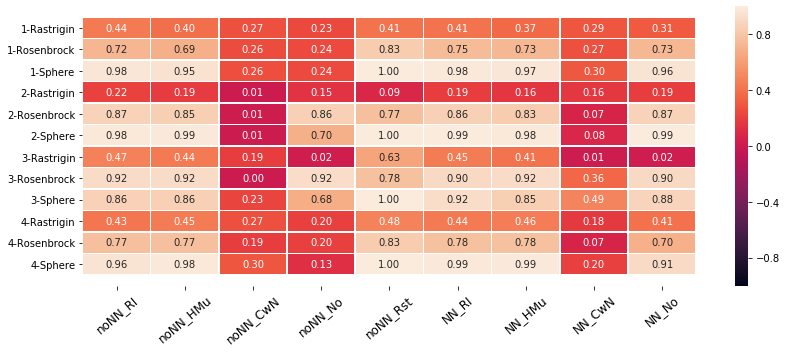

In [15]:
fig,ax = plt.subplots(figsize=(12,5))
sns.heatmap(summary, annot=True, linewidths=.5, ax=ax, cmap=sns.cm.rocket, vmin=-1, fmt='.2f',)
u,l = ax.get_ylim()
ax.set_ylim(u+0.5, l-0.5)
ax.set_ylabel('')
ax.set_xlabel('')
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12)
    tick.label.set_rotation(40)
    
for tick in ax.yaxis.get_major_ticks(): tick.label.set_fontsize(10)
plt.tight_layout()
fig.savefig(path/'heatmapSR.eps', dpi=400, format='eps')